In [1]:
from pycuda import gpuarray
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%load_ext autoreload
%autoreload 1

In [2]:
ker = SourceModule("""
#define _x (threadIdx.x + blockIdx.x * blockDim.x)
#define _y (threadIdx.y + blockIdx.y * blockDim.y)

#define _width (blockDim.x * gridDim.x) //total number of threads in dimension 0
#define _height (blockDim.y * gridDim.y) //total number of threads in dimension 1

#define _xm(x) ( (x + _width) % _width )
#define _ym(y) ( (y + _height) % _height )

#define _index(x, y) (_xm(x) + _ym(y) * _width)

__device__ int nbrs(int x, int y, int * in) {
    return in[_index(x-1, y-1)] + in[_index(x-1, y)] + in[_index(x-1, y+1)] \
           + in[_index(x, y-1)] + in[_index(x, y+1)] \
           + in[_index(x+1, y-1)] + in[_index(x+1, y)] + in[_index(x+1, y+1)];
}

__global__ void conway_ker(int * lattice_out, int * lattice) {
    int x = _x, y = _y;
    int n = nbrs(x, y, lattice);
    if (lattice[_index(x, y)] == 1)
        switch (n) {
            case 2:
            case 3: lattice_out[_index(x, y)] = 1;
                    break;
            default: lattice_out[_index(x, y)] = 0;
        }
    else if (lattice[_index(x, y)] == 0 )
        switch(n) {
            case 3: lattice_out[_index(x, y)] = 1;
                    break;
            default: lattice_out[_index(x, y)] = 0;
        }
}
""")
conway_ker = ker.get_function("conway_ker")

In [34]:
def update_gpu(newLattice_gpu, lattice_gpu, N):
    for i in range(300):
        conway_ker(newLattice_gpu, lattice_gpu, grid=(N//32, N//32, 1), block=(32, 32, 1))
        tmp = lattice_gpu
        lattice_gpu = newLattice_gpu
        newLattice_gpu = tmp
        plt.imshow(lattice_gpu.get())
        plt.show()
        clear_output(wait=True)

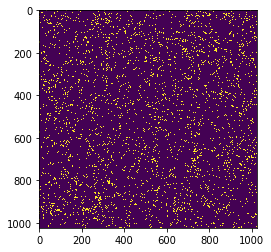

In [37]:
N = int(32 * 32)
lattice = np.random.choice([1, 0], N*N, p=[.25, .75]).reshape(N, N).astype('int32')
lattice_gpu = gpuarray.to_gpu(lattice)
newLattice_gpu = gpuarray.empty_like(lattice_gpu)
update_gpu(newLattice_gpu, lattice_gpu, N)